# Introduction

Here I'm showing how to use the code for preferential exploration.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import seaborn as sns
import pandas as pd
import funcs as f1
import time, pickle, random, copy
from funcs import *
%matplotlib inline


def run_PE(par):
    
    [alpha, rho, gamma, R, nu, num_agents] = par
    
    #Parametersa
    num_steps,num_trials,box_size = 10**3, 1,1,

    #Iterate over differennt individuals
    Ngrid = 300;
    n_lower, n_upper = 100, 200
    possible_homes = [(i,j) for i in range(n_lower, n_upper) for j in range(n_lower,n_upper)]
    homes = [random.choice(possible_homes) for _ in range(num_agents)]

    #Do simulation
    data = {}
    t1 = time.time()
    for i,(x_start, y_start) in enumerate(homes):
        agent_id = i
        x_curr, y_curr = x_start, y_start
        data = preferential_exploration(num_steps,data,alpha,rho,gamma,R,nu,x_curr,y_curr, \
                                          agent_id,Ngrid,box_size)
    t2 = time.time()
    print('took ' + str( (t2-t1)/60.0 ) + ' mins')

    #Save data
    filename = 'data/EPE_lattice_alpha_{}_rho_{}_gamma_{}_R_{}_nu_{}_Nagent_{}.pkl'.format(alpha, \
                                                                            rho,gamma,R,nu,num_agents)
    with open(filename,'wb') as g:
        pickle.dump(data,g)
     
    #Plot data
    f1.spatial_plot(data,homes,Ngrid)
        
    return data, homes, Ngrid



def plot_rf(data, par):
    
    [alpha, rho, gamma, R, nu, num_agents] = par
    num_bins = 20
    fs = [1,2,4,8]

    plt.figure(figsize=(20,5))
    plt.subplot(131)

    #Plot N versus r
    for f1 in fs:
        rs = []
        for cell in data.keys():
            vals = data[cell]
            for agent_ID, f_temp, home, r, E in vals:
                if f_temp == f1:
                    if r != 0:
                        rs.append(r)
        #Plot rs
        bins = np.linspace(min(rs),10**2,num_bins)
        frq, edges = np.histogram(rs, bins)
        mid = [0.5*(edges[i] + edges[i+1]) for i in range(len(edges)-1) ]
        plt.loglog(mid, frq,'o-')
    plt.legend(['f = ' + str(f1) for f1 in fs],frameon=False)
    plt.xlabel('$r$', fontsize=18)
    plt.ylabel('$N_f(r)$', fontsize=18)


    #Plot N versus r*f
    plt.subplot(132)
    for f1 in fs:
        rs = []
        for cell in data.keys():
            vals = data[cell]
            for agent_ID, f_temp, home, r, E in vals:
                if f_temp == f1:
                    if r != 0:
                        rs.append(r*f_temp)
        #Plot rs
        bins = np.linspace(min(rs),10**2,num_bins)
        frq, edges = np.histogram(rs, bins)
        mid = [0.5*(edges[i] + edges[i+1]) for i in range(len(edges)-1) ]
        plt.loglog(mid, frq,'o-')
    plt.legend(['f = ' + str(f1) for f1 in fs],frameon=False)
    plt.xlabel('$r f$', fontsize=18)


    #Plot N versus r*f^2
    plt.subplot(133)
    for f1 in fs:
        rs = []
        for cell in data.keys():
            vals = data[cell]
            for agent_ID, f_temp, home, r, E in vals:
                if f_temp == f1:
                    if r != 0:
                        rs.append(r*f_temp**2)

        #Plot rs
        bins = np.linspace(min(rs),10**3,num_bins)
        frq, edges = np.histogram(rs, bins)
        mid = [0.5*(edges[i] + edges[i+1]) for i in range(len(edges)-1) ]
        plt.loglog(mid, frq,'o-')
    plt.legend(['f = ' + str(f1) for f1 in fs],frameon=False)
    plt.xlabel('$r f^2$', fontsize=18)
    filename = 'figures/EPR_lattice_alpha_{}_rho_{}_gamma_{}_Nagent_{}.pdf'.format(alpha,rho,gamma,num_agents)
    plt.savefig(filename)
    
    
    
def plot_visitation(data,Ngrid):
    V, E = np.zeros((Ngrid, Ngrid)), np.zeros((Ngrid, Ngrid)),
    for key in data.keys():

        #Find visitation
        vals = data[key]
        x,y = cell_id_to_xy(key,Ngrid)
        visitation = len(vals) 
        V[x][y] = visitation

        #Find energy
        Es = []
        for agent_ID, f_temp, home, r, E1 in vals:
            Es.append(E1)
        E_mean = np.mean(Es)
        E[x][y] = E_mean


    vs = V.flatten()
    v_clean = [x for x in vs if x != 0]
    plt.hist(v_clean)
    plt.xlabel('visitation')
    
    
def preferential_exploration(num_steps,data,alpha,rho,gamma,R, nu, x_curr,y_curr,agent_id,Ngrid,box_size):
    
    #Update the data
    home = xy_to_cell_id(x_curr,y_curr,Ngrid)
    f, r, E = 1,0,0
    val = [agent_id, f, home, r, E]
    if home not in data:
        data[home] = [val]
    else:
        data[home].append(val)
    visited_places = {}  # {(x,y):freq}
    visited_places[(x_curr,y_curr)] = 1

    for i in range(num_steps-1):
        
        #Find odds of exploring new location
        num_visited = len(visited_places)
        prob_new = rho*num_visited**(-gamma)   #defined in the Song model
        temp = np.random.rand()

        #Go to new location
        if temp <= prob_new:
            x_curr, y_curr = levy_jump_with_PE(x_curr, y_curr, alpha, R, nu, box_size, data, Ngrid)

            #If jump has taken you outside the box, stop    
            if  x_curr < 0 or x_curr >= Ngrid or y_curr < 0 or y_curr >= Ngrid:
                break
            visited_places = add_to_visited_places(x_curr, y_curr, visited_places)
            data = update_data(x_curr, y_curr, home, data, agent_id, Ngrid) 
            
        #Return to previously visited location   
        else:
            x_curr, y_curr, visited_places = revisit(visited_places)
            cell_id = xy_to_cell_id(x_curr, y_curr, Ngrid)
            list_of_agents = data[cell_id]
        
            #find index of 
            for j in range(len(list_of_agents)):
                if list_of_agents[j][0] == agent_id:
                    break
                    
            #then update that list
            [agent_id, f, home, r, E] = list_of_agents[j]            
            new_row = [agent_id, f+1, home, r, r*(f+1)]
            data[cell_id][j] = new_row
    return data

/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:850: MatplotlibDeprecationWarning: 
The text.dvipnghack rcparam was deprecated in Matplotlib 2.1 and will be removed two minor releases later.
  version, name=key, obj_type="rcparam", alternative=alt_key)

Bad key "axes.color_cycle" on line 242 in
/Users/Kev/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


### Test for $N = 10^2$ agents

took 0.11377944548924764 mins


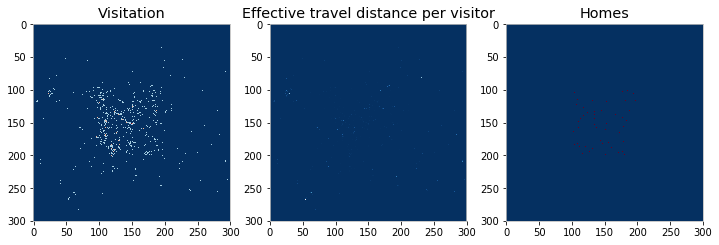

In [14]:
alpha, rho, gamma, R, nu, num_agents = 0.55, 0.6, 0.21, 10, 4, 10**2
par = [alpha, rho, gamma, R, nu, num_agents]
data, homes, Ngrid = run_PE(par)

### $N = 10^4$ agents

took 14.559023161729177 mins


/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


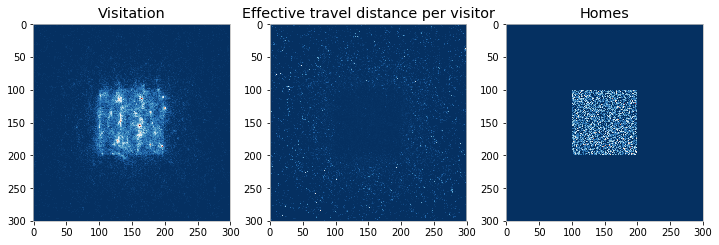

In [2]:
alpha, rho, gamma, R, nu, num_agents = 0.55, 0.6, 0.21, 10, 4, 10**4
par = [alpha, rho, gamma, R, nu, num_agents]
data, homes, Ngrid = run_PE(par)

### N = 10^5

took 348.4695614814758 mins


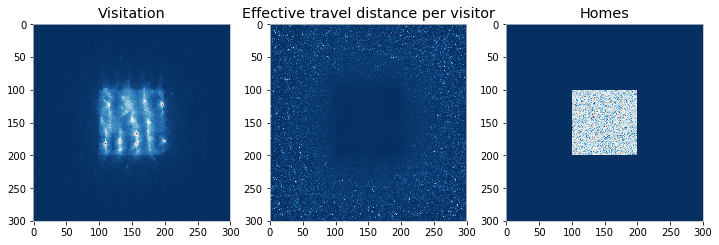

In [16]:
alpha, rho, gamma, R, nu, num_agents = 0.55, 0.6, 0.21, 10, 4, 10**5
par = [alpha, rho, gamma, R, nu, num_agents]
data, homes, Ngrid = run_PE(par)